In [4]:
import pytest
import torch

from spflows.configs_classes.gecko_configs import GeckoModelConfig
from spflows.data.datamodules import GeckoDatamodule
from spflows.data.gecko.gecko_datasets import CoinGeckoDataset
from spflows.data.gecko.gecko_metadata import AllCoinsMetadata,CoinMetadata
from spflows.data.gecko.gecko_utils import get_dataframe_with_freq_bitcoin,get_dataframe_with_freq_from_bitcoin
from spflows.data.gecko.gecko_requests import (
    get_key
)
from spflows.training.gecko_experiments import GeckoLightningExperiment
from gluonts.evaluation.backtest import make_evaluation_predictions


In [3]:
experiment_dir = r"C:\Users\cesar\Desktop\Projects\BirthDeathPortfolio\stochastic_process_flows\results\1734628682"
device = "cuda" if torch.cuda.is_available() else "cpu"
experiment = GeckoLightningExperiment(experiment_dir=experiment_dir,map_location=device)
databatch = experiment.datamodule.get_train_databatch()
databatch = experiment.datamodule.send_tensors_to_device(databatch,device)
inputs = list(databatch.values())
loss = experiment.model.train_dynamical_module(*inputs)

100%|██████████| 3049/3049 [00:03<00:00, 1012.47it/s]


Loaded 926 existing time series.
Setting Data Frequencies


100%|██████████| 925/925 [00:00<00:00, 1428.31it/s]


In [7]:
config = experiment.config
model = experiment.model
datamodule = experiment.datamodule

predictor = model.create_predictor_network(
    transformation=datamodule.transformations,
    prediction_splitter=datamodule.create_instance_splitter("test"),
)
forecast_it, ts_it = make_evaluation_predictions(dataset=datamodule.test_data,
                                                    predictor=predictor,
                                                    num_samples=100)

In [13]:
forecasts = list(forecast_it)
targets = list(ts_it)

In [22]:
forecasts, targets = model.define_predictor_and_sample(datamodule)

In [29]:
forecasts[0].samples.shape

(10, 96, 6)

In [31]:
targets[0]

,0,1,2,3,4,5
2024-09-19 16:00,63156.582031,1.248483e+12,5.469172e+10,NaN,NaN,NaN
2024-09-19 17:00,63691.949219,1.258389e+12,5.638283e+10,NaN,NaN,NaN
2024-09-19 18:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-19 19:00,63710.851562,1.255482e+12,5.364823e+10,NaN,NaN,NaN
2024-09-19 20:00,63326.750000,1.251173e+12,4.810758e+10,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-12-18 13:00,105037.054688,2.078248e+12,1.057615e+11,NaN,NaN,NaN
2024-12-18 14:00,104983.484375,2.072129e+12,1.067835e+11,NaN,NaN,NaN
2024-12-18 15:00,104661.921875,2.070168e+12,1.061015e+11,NaN,NaN,NaN
2024-12-18 16:00,103821.250000,2.057638e+12,1.003946e+11,NaN,NaN,NaN


C:\Users\cesar\AppData\Local\Temp\ipykernel_17272\2389512411.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


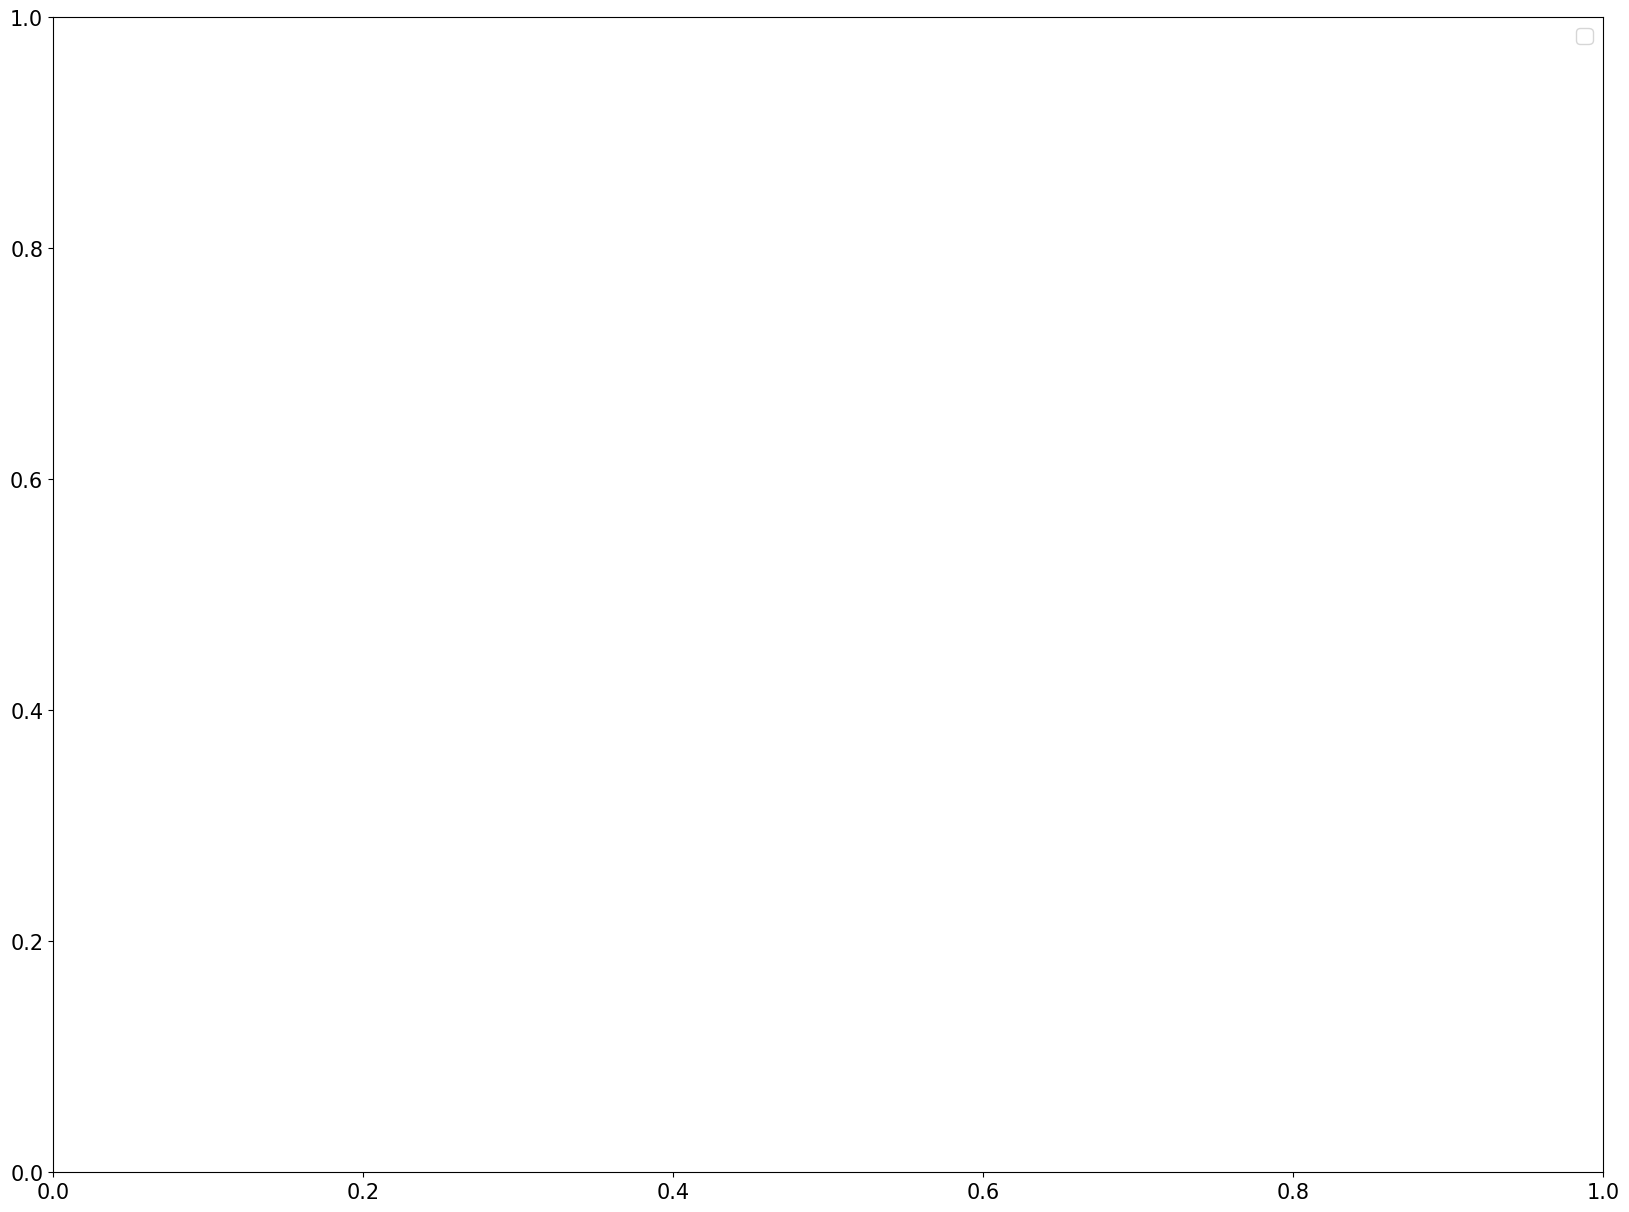

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, targets)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * config.prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()